In [1]:
#!pip install tensorflow

In [27]:
import psycopg2
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Dropout,Flatten,LeakyReLU,Conv1D,MaxPooling1D, Activation,SpatialDropout1D,GlobalAveragePooling1D,BatchNormalization
from keras.models import model_from_json
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [28]:
conn=psycopg2.connect(database='mimiciv',user='hyu',password='qlrqod123',host='127.0.0.1',port='5432')
print('Open successfully')
cursor=conn.cursor()

Open successfully


In [29]:
patient=pd.read_sql_query('select distinct on (patient.subject_id) patient.subject_id,gender,anchor_age, ethnicity,icd_code from mimiciv.admission inner join mimiciv.patient on admission.subject_id=patient.subject_id inner join mimiciv.diagnoses_icd on diagnoses_icd.subject_id=patient.subject_id order by patient.subject_id',conn)
patient.drop(patient[(patient.anchor_age==0)].index,axis=0,inplace=True)
patient.reset_index(drop=True,inplace=True)
print(patient.shape)

(194275, 5)


In [4]:
icd_code=pd.read_sql_query("select distinct on(subject_id) subject_id,icd_code from mimiciv.diagnoses_icd where icd_code like '%E65%'or icd_code like '%E66%' or icd_code like '%E67%' or icd_code like '%E68%' or icd_code like '278%' or icd_code like '%O9921%'or icd_code like '6491%' order by subject_id",conn)
print(len(icd_code))

22555


In [5]:
ids=list(icd_code['subject_id'])
for i in ids:
    patient.loc[(patient.subject_id==i),'icd_code']='1'

In [6]:
patient.icd_code.value_counts()

1          22552
4019        4748
2724        2341
30500       2096
I10         2096
           ...  
I444           1
64682          1
C8221          1
V00328A        1
7513           1
Name: icd_code, Length: 10757, dtype: int64

In [7]:
chartevent=pd.read_sql_query('select subject_id,charttime,itemid,value,valueuom from mimiciv.chartevents where itemid=226730 or itemid=226512 or itemid=220621 order by subject_id,itemid,charttime',conn)
chartevent['value']=pd.to_numeric(chartevent['value'],errors='coerce')
chartevent.drop_duplicates(['subject_id','itemid'],keep='first',inplace=True)
chartevent.reset_index(drop=True,inplace=True)
chartfeatures=chartevent.pivot(index='subject_id',columns='itemid',values='value')
chartfeatures.reset_index(inplace=True)
# chartfeatures.dropna(subset=[226730],axis=0,inplace=True)
# chartfeatures.reset_index(drop=True,inplace=True)
chartfeatures_fillna=chartfeatures.fillna(chartfeatures.mean())
print(chartfeatures_fillna.shape)

(53129, 4)


In [8]:
chartfeatures_fillna.columns=['subject_id','glucose','weight','height']
df_new=patient.merge(chartfeatures_fillna)
df_new.rename(columns={'anchor_age':'age'},inplace=True)
df_new.loc[df_new['icd_code']!='1','icd_code']=0
df_new.icd_code.value_counts()

0    44855
1     8258
Name: icd_code, dtype: int64

In [9]:
df_new.drop('subject_id',axis=1,inplace=True)

#Drop some abnormal value
df_new.drop(df_new[df_new.glucose>1000].index,axis=0,inplace=True)
df_new.drop(df_new[df_new.weight>200].index,axis=0,inplace=True)
df_new.drop(df_new[df_new.height>200].index,axis=0,inplace=True)

df_new.reset_index(drop=True,inplace=True)
df_new.shape

(52930, 7)

In [10]:
df_new.drop(df_new[df_new.height==0].index,axis=0,inplace=True)
df_new.reset_index(drop=True,inplace=True)
df_new['BMI']=round(df_new['weight']/((df_new['height']/100)**2),2)
df_new.drop(df_new[df_new['BMI']>100].index,axis=0,inplace=True)
df_new.reset_index(drop=True,inplace=True)

df_new=df_new[['age','gender','glucose','weight','height','BMI','icd_code']]
df_new

,age,gender,glucose,weight,height,BMI,icd_code
0,52,F,115.000000,39.4,152.000000,17.05,0
1,73,F,372.709865,76.2,168.824223,26.74,1
2,55,F,113.000000,71.2,168.824223,24.98,0
3,46,F,146.000000,72.2,157.000000,29.29,0
4,68,F,148.000000,65.0,157.000000,26.37,0
...,...,...,...,...,...,...,...
52743,41,M,136.000000,107.5,193.000000,28.86,0
52744,81,M,175.000000,50.5,168.824223,17.72,0
52745,46,F,192.000000,67.9,168.824223,23.82,0
52746,58,M,98.000000,77.5,178.000000,24.46,0


In [11]:
df_final=df_new.copy()
gender_map={'M':0,'F':1}
df_final['gender']=df_final['gender'].map(gender_map)
df_final.icd_code=pd.to_numeric(df_final.icd_code,errors='coerce')

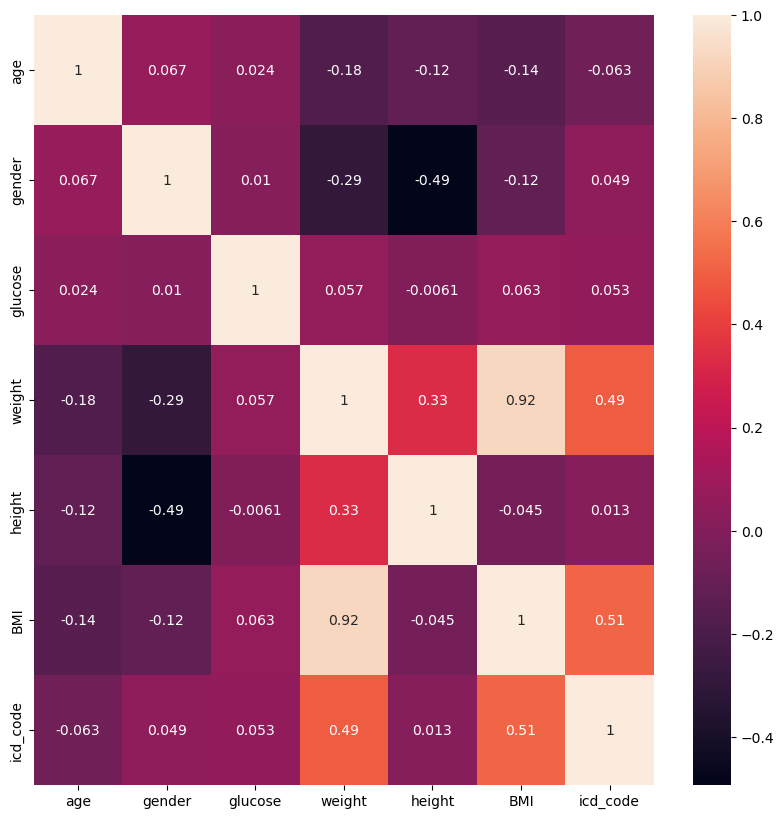

In [12]:
fig=plt.subplots(figsize=(10,10))
ht=df_final.corr()
sns.heatmap(ht,annot=True)
plt.show()

In [13]:
df_final[['glucose','icd_code']]
df_final.icd_code.value_counts()

0    44628
1     8120
Name: icd_code, dtype: int64

In [14]:
df_abnormal=df_final.loc[(df_final.glucose>=100),:]
df_abnormal.icd_code.value_counts()

0    35404
1     6894
Name: icd_code, dtype: int64

In [15]:
df_abnormal_only=df_abnormal.loc[df_abnormal.icd_code==1,:]
df_abnormal_only.reset_index(drop=True,inplace=True)
df_abnormal_only

,age,gender,glucose,weight,height,BMI,icd_code
0,73,1,372.709865,76.2,168.824223,26.74,1
1,72,1,148.000000,93.0,168.000000,32.95,1
2,47,0,425.000000,127.0,183.000000,37.92,1
3,66,0,118.000000,91.0,173.000000,30.41,1
4,52,0,134.000000,81.4,168.824223,28.56,1
...,...,...,...,...,...,...,...
6889,50,0,111.000000,125.8,180.000000,38.83,1
6890,50,1,122.000000,102.2,156.000000,42.00,1
6891,41,1,114.000000,91.0,168.824223,31.93,1
6892,76,0,172.000000,134.5,180.000000,41.51,1


In [16]:
df_normal=df_final.loc[(df_final.glucose<100),:]
df_normal.icd_code.value_counts()

0    9224
1    1226
Name: icd_code, dtype: int64

In [17]:
df_normal_only=df_normal.loc[df_normal.icd_code==0,:]
df_normal_only.reset_index(drop=True,inplace=True)
df_normal_only

,age,gender,glucose,weight,height,BMI,icd_code
0,80,1,95.0,53.0,168.824223,18.60,0
1,21,0,88.0,82.0,178.000000,25.88,0
2,80,1,99.0,43.0,150.000000,19.11,0
3,24,0,90.0,67.0,168.824223,23.51,0
4,56,0,99.0,91.0,185.000000,26.59,0
...,...,...,...,...,...,...,...
9219,52,1,70.0,85.0,160.000000,33.20,0
9220,47,0,78.0,70.0,157.000000,28.40,0
9221,52,1,93.0,49.4,157.000000,20.04,0
9222,42,0,67.0,68.8,165.000000,25.27,0


In [18]:
from sklearn.utils import shuffle
df=pd.concat([df_abnormal_only,df_normal_only])
df_shuffled=shuffle(df)
df_shuffled=df_shuffled.reset_index(drop=True)
df_shuffled

,age,gender,glucose,weight,height,BMI,icd_code
0,68,1,93.0,63.0,163.000000,23.71,0
1,25,0,96.0,85.0,183.000000,25.38,0
2,86,0,184.0,117.0,168.824223,41.05,1
3,85,1,88.0,69.5,160.000000,27.15,0
4,64,0,122.0,139.9,180.000000,43.18,1
...,...,...,...,...,...,...,...
16113,35,1,76.0,75.0,168.824223,26.31,0
16114,59,0,98.0,112.0,168.824223,39.30,0
16115,38,1,92.0,81.8,168.824223,28.70,0
16116,53,1,90.0,54.0,168.824223,18.95,0


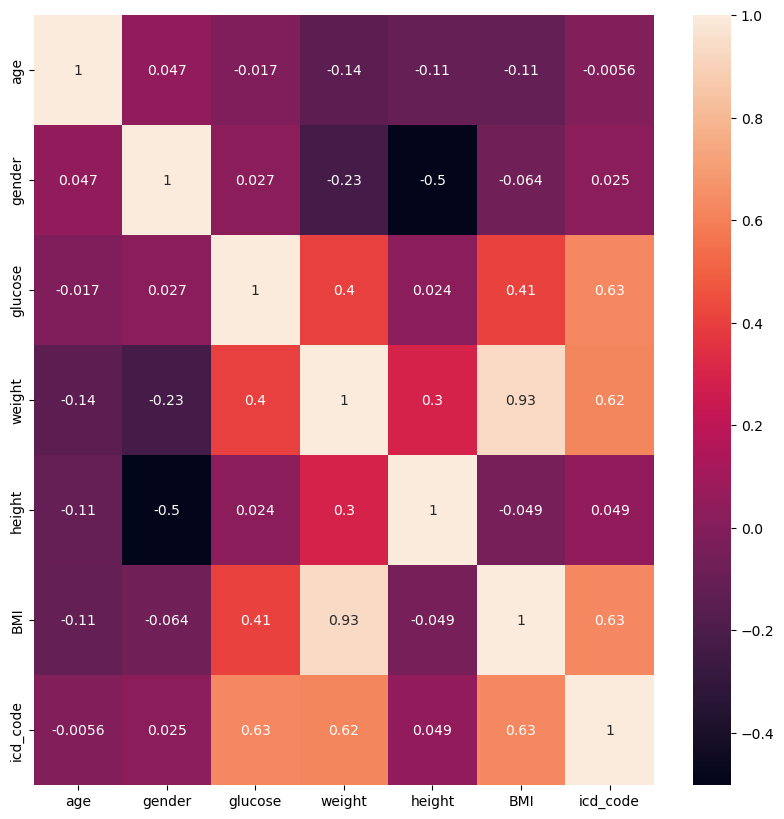

In [19]:
fig=plt.subplots(figsize=(10,10))
ht=df_shuffled.corr()
sns.heatmap(ht,annot=True)
plt.show()

In [20]:
df_shuffled.to_csv('df_final_version.csv',index=False)
df_shuffled=pd.read_csv('df_final_version.csv')

In [21]:
# Y=df_shuffled[['icd_code']].values
# X=df_shuffled[['age','gender','glucose','weight','height','BMI']].values

# scaler=MinMaxScaler()
# scaler.fit(X)
# X_scaled=scaler.transform(X)
# Y_onehot=np_utils.to_categorical(Y)
# X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y_onehot,test_size=0.2,random_state=0)


In [22]:
# def dnn_model():
#     model=Sequential()
#     model.add(Dense(32,input_shape=(9,),activation='relu'))
#     model.add(Dense(32,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(64,activation='relu'))
#     model.add(Dense(64,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.4))
#     model.add(Dense(16,activation='relu'))
#     model.add(Dense(16,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.4))
#     model.add(Dense(8,activation='relu'))
#     model.add(Dense(8,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(2,activation='softmax'))
#     return model
# dnn=dnn_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# dnn.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
# history=dnn.fit(X_train,y_train,batch_size=64,epochs=200,shuffle=False,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])

In [23]:
# score=dnn.evaluate(X_test,y_test)
# print('Test loss:',score[0])
# print('Test accuracy:',score[1])
# plt.plot(history.epoch,history.history.get('val_accuracy'),c='g',label='validation acc')
# plt.plot(history.epoch,history.history.get('accuracy'),c='b',label='train acc')
# plt.legend()

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score,f1_score,precision_score
# pred=np.argmax(dnn.predict(X_test),axis=1)
# y_t=np.argmax(y_test,axis=1)
# print('precision score:',precision_score(y_t,pred))
# print('f1 score:',f1_score(y_t,pred))
# print('recall score:',recall_score(y_t,pred))
# print('accuracy score:',accuracy_score(y_t,pred))

Epoch 1/200
429/429 [==============================] - 5s 9ms/step - loss: 0.4644 - accuracy: 0.7789 - val_loss: 0.3224 - val_accuracy: 0.8734
Epoch 2/200
429/429 [==============================] - 3s 7ms/step - loss: 0.2951 - accuracy: 0.8797 - val_loss: 0.2536 - val_accuracy: 0.9036
Epoch 3/200
429/429 [==============================] - 4s 8ms/step - loss: 0.2322 - accuracy: 0.9088 - val_loss: 0.1891 - val_accuracy: 0.9289
Epoch 4/200
429/429 [==============================] - 4s 8ms/step - loss: 0.1890 - accuracy: 0.9308 - val_loss: 0.1402 - val_accuracy: 0.9504
Epoch 5/200
429/429 [==============================] - 4s 8ms/step - loss: 0.1523 - accuracy: 0.9471 - val_loss: 0.1145 - val_accuracy: 0.9624
Epoch 6/200
429/429 [==============================] - 3s 8ms/step - loss: 0.1265 - accuracy: 0.9572 - val_loss: 0.0968 - val_accuracy: 0.9706
Epoch 7/200
429/429 [==============================] - 4s 9ms/step - loss: 0.1160 - accuracy: 0.9622 - val_loss: 0.0890 - val_accuracy: 0.9723

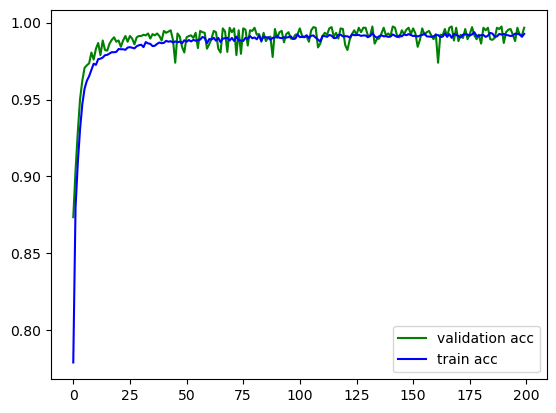

In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

Y=df_shuffled[['icd_code']].values
X=df_shuffled[['glucose','age','gender','weight','BMI','height']].values

scaler=MinMaxScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)
X_scaled=np.expand_dims(X_scaled,axis=2) 
joblib.dump(scaler, '/Data4TB/zhan/mimiciv_obesity/scaler.pkl') 

Y_onehot=np_utils.to_categorical(Y)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y_onehot,test_size=0.15,random_state=0)
def cnn_model():
    model=Sequential()
    model.add(Conv1D(32,3,input_shape=(6,1),activation='tanh',padding='same'))
    model.add(MaxPooling1D(3,padding='same'))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64,3,activation='tanh',padding='same'))
    model.add(MaxPooling1D(3,padding='same'))
    model.add(SpatialDropout1D(0.3))
    model.add(Flatten())
    model.add(Dense(2,activation='softmax'))
    # print(model.summary())
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
cnn=cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# estimator=KerasClassifier(build_fn=cnn_model,epochs=200,batch_size=16,verbose=1,validation_data=(X_test,y_test))
history=cnn.fit(X_train,y_train,epochs=200,batch_size=32,shuffle=False,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])
score=cnn.evaluate(X_test,y_test)
print('Test loss:',score[0])
print('Test accuracy:',score[1])
plt.plot(history.epoch,history.history.get('val_accuracy'),c='g',label='validation acc')
plt.plot(history.epoch,history.history.get('accuracy'),c='b',label='train acc')
plt.legend()

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score,f1_score,precision_score
pred=np.argmax(cnn.predict(X_test),axis=1)
y_t=np.argmax(y_test,axis=1)
print('precision score:',precision_score(y_t,pred))
print('f1 score:',f1_score(y_t,pred))
print('recall score:',recall_score(y_t,pred))
print('accuracy score:',accuracy_score(y_t,pred))

76/76 [==============================] - 1s 6ms/step
precision score: 0.9990448901623686
f1 score: 0.9961904761904762
recall score: 0.99335232668566
accuracy score: 0.9966914805624483


In [33]:
cnn.save("obesity.h5")